In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import murraylab_tools.biotek as btek
import itertools
import glob

%matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
from matplotlib.patches import Patch

mpl.font_manager._rebuild()
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

%matplotlib inline
%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Roboto'], 
                 'serif': ['Roboto'],'weight':'normal'})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

In this Jupyter notebook, we will fit the flow cytometry results from mScarletI with KDEs, assign individual cells to peaks, then determine the fractions that are 'on' and 'off' in each well. These fractions will be used to generate the plots for Figure 3F. Code below is modified from code kindly provided by Andy Halleran on the Github repositiory: https://github.com/andyhalleran/flow_tools/blob/. Functions with 'RW' have been modified from the original code available on this repository, or are new functions.

In [2]:
def get_values(file_directory, channel='GFP/FITC-A',bg_add=0):
    ''' Reads in the values from a specific channel for a given flow file.
    Defaults to taking GFP/FITC-A.'''
    flow_data = pd.read_csv(file_directory)
    flow_data_gfp_values = np.log10(flow_data[channel].values + bg_add)
    return flow_data_gfp_values


In [3]:
def make_df(file_directory, channel_1='GFP/FITC-A', channel_2=None, bg_add_1 = 0, bg_add_2 = 0):
    '''Creates a dataframe from the given file directory. Reads in all csvs, 
    extracts the data from the channel of interest (defaults to GFP/FITC-A), 
    and returns one dataframe.'''
    all_files = glob.glob(file_directory)
    all_files.sort()
    
    all_data_1 = []
    for file in all_files:
        data = get_values(file, channel=channel_1, bg_add=bg_add_1)
        all_data_1.append(data)
    
    if channel_2 != None:
        all_data_2 = []
        for file in all_files:
            data = get_values(file, channel=channel_2, bg_add=bg_add_2)
            all_data_2.append(data)
            
    labels = []
    for i in range(0, len(all_files)):
        mini_label = str(all_files[i].split('.')[-2])
        label = [mini_label]*len(all_data_1[i])
        labels.append(label)
    
    flat_all_data_1 = [item for sublist in all_data_1 for item in sublist]
    flat_all_data_2 = [item for sublist in all_data_2 for item in sublist]
    flat_labels = [item for sublist in labels for item in sublist]
    
    if channel_2 == None:
        df = pd.DataFrame(dict(well=flat_labels, log10sfGFP=flat_all_data_1))
    else:
        df = pd.DataFrame(dict(well=flat_labels, log10GFP=flat_all_data_1, log10mScarletI=flat_all_data_2))
    return df
        

In [4]:
def get_peak_locations_from_KDE_fit(data):
    ''' Performs a KDE fit and then uses scipy.signal.find_peaks_cwt to get peaks.
        The KDE bandwith parameter is critical, and 0.25 has worked well in the past.
        If it feels like you are missing many peak calls, decrease the bandwith. If it feels
        like you are having too many peak calls, increase the bandwith. 
        
        Don't change the bandwith without good reason, it took awhile to decide on 0.25. '''
    
    kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
    kde.fit(data[:, None]);

    x_range = np.linspace(0, 6, 1200)
    kde_estimates = np.exp(kde.score_samples(x_range[:, None]))

    #Use the SciPy function to get the KDE peaks
    peaks = signal.find_peaks_cwt(kde_estimates, np.arange(30, 200), min_snr=1)

    means_init = []
    
    for peak in peaks:
        means_init.append(x_range[peak])
    
    return means_init



In [5]:
def fit_GMM_KDE_RW(data, peaks, threshold = 0.01,return_labels=False): 
    """Generate a Gaussian mixture model from the output
    of a Gaussian Kernel Density Estimation. 
    Outputs the mean of the on peak, fraction on, mean of the off peak, 
    and fraction off. This version of the code assumes all cells not in the on peak are off!
    This is obviously only a good assumption for uni/bimodal data. If you have multimodal data,
    do not use this code."""
    
    data = data.reshape(len(data), 1)
    
    peaks = np.array(peaks).reshape(len(peaks), 1)
    opt_gmm = GaussianMixture(n_components = len(peaks) , means_init = peaks).fit(data)  
    
    labels = opt_gmm.predict(data)
    labels_return = labels.copy()
    
    labels = np.ravel(labels.reshape(len(labels), 1))
    means = opt_gmm.means_

    df = pd.DataFrame({'gfp': np.ravel(data), 'distribution': labels})
    
    df.head(10)
    counts = []
    means = []
    
    
    
    for i in range(0, len(peaks)):
        df_distro = df.loc[df['distribution']==i]
        counts.append(len(df_distro))
        means.append(np.mean(df_distro['gfp'].values))
    print(means)
    print('counts = ', counts)
    print('means = ', means)
    total = len(df)
    
    fractions = np.array(counts)/total
    if return_labels:
        return means, fractions, labels_return
    
    ##Initializing corrected lists of means and fractions of subpopulations
    GMM_accepted_means = []
    
    GMM_corrected_fractions = []
    
    for i in range(0, len(fractions)):
        if fractions[i] > threshold: 
            GMM_accepted_means.append(means[i])
            GMM_corrected_fractions.append(fractions[i])    
    
    return GMM_accepted_means, GMM_corrected_fractions

In [6]:
def fit_GMM_KDE_wrapper_RW(data,return_labels=False):
    """Wrapper function to get both the peaks from a KDE fit, and then 
    from the Gaussian mixture model. Returns the mean of the broken cells, 
    and the fraction of broken cells."""
    
    peak_locations= get_peak_locations_from_KDE_fit(data)
    
    if return_labels:
        means, fractions, labels = fit_GMM_KDE_RW(data, peak_locations, threshold = 0.01,return_labels=return_labels)
        return means, fractions, labels 
    else:
        means, fractions = fit_GMM_KDE_RW(data, peak_locations, threshold = 0.01,return_labels=return_labels)
        return means, fractions
   

In [7]:
def fit_GMM_KDE_wrapper (data):
    """Wrapper function to get both the peaks from a KDE fit, and then 
    from the Gaussian mixture model. Returns the mean of the broken cells, 
    and the fraction of broken cells."""
    
    peak_locations= get_peak_locations_from_KDE_fit(data)
    
    mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, fraction_off = fit_GMM_KDE(data, peak_locations, threshold = 0.01)
    
    return mean_of_highest_peak, fraction_of_highest_peak, mean_of_off_population, fraction_off

In [8]:
def GMM_method_RW(df_, wells,col='log10GFP'):
    '''
    Wrapper function for the the entire generation of the final output df. 
    Takes the input dataframe and a list of all wells you want to perform GMM fitting on.
    '''
    means_df = []
    fractions_df = []
    wells_df = []
    
    for well in wells:
        data = df_.loc[df_['well'] == well]
        
        XFP = data[col].values
        if len(XFP)<1000:
            print('error: well ' + well + 'has too few cells')
        else:
            means, fractions = fit_GMM_KDE_wrapper_RW(XFP)

            means_df = means_df + means
            fractions_df = fractions_df + fractions
            wells_df = wells_df + len(means)*[well,]
        

    plt_df = pd.DataFrame({'mean': means_df, 'fraction' : fractions_df,
                           'well': wells_df})
    
    return plt_df

In [9]:
def GMM_method_return_labeled_RW(df_, wells,peak_col='log10mScarletI',return_cols=np.array(['log10GFP','log10mScarletI'])):
    '''
    Wrapper function for the the entire generation of the final output df. Takes the input dataframe 
    and a list of all wells you want to perform GMM fitting on. Returns data frame with fractions and means
    of all peaks for each well. Also returns data frame with all cells from all wells with the peak they
    belong to, and both the log10GFP and log10mScarletI values for each cell. 
    '''
    means_df = []
    fractions_df = []
    wells_df = []
    XFP1_df = []
    XFP2_df = []
    labels_df = []
    labels_means_df = []
    labels_wells_df = []
    
    for well in wells:
        data = df_.loc[df_['well'] == well]
        
        XFP = data[peak_col].values
        if len(XFP)<1000:
            print('error: well ' + well + 'has too few cells')
        else:
            means, fractions, labels = fit_GMM_KDE_wrapper_RW(XFP,return_labels=True)
            means_df = means_df + list(means)
            fractions_df = fractions_df + list(fractions)
            wells_df = wells_df + len(means)*[well,]
            XFP1_df = XFP1_df + list(data[return_cols[0]].values)
            XFP2_df = XFP2_df + list(data[return_cols[1]].values)
            labels_wells_df = labels_wells_df + len(labels)*[well,]
            labels_df = labels_df + list(labels)
            means_array = np.array(means)
            labels_means_df = labels_means_df + list(means_array[labels])
            
        

    plt_df = pd.DataFrame({'mean': means_df, 'fraction' : fractions_df,
                           'well': wells_df})
    
    labeled_df = pd.DataFrame({'well': labels_wells_df, return_cols[0] : XFP1_df,
                           return_cols[1] : XFP2_df, 'peak_num' : labels_df,'peak_mean': labels_means_df})
    
    return plt_df, labeled_df

In [11]:
def select_wells(df, wells):
    """
    Returns dataframe with only wells in 'wells'
    """
    for i, well in enumerate(wells):

        if i == 0:
            df_select = df.loc[df.well==well,:]
        else:
            df_add = df.loc[df.well==well,:]
            df_select = pd.concat([df_select, df_add])
    return df_select

def add_metadata(df, metadata_fs, cols=['sal','las','chlor','replicate']):
    """
    Returns dataframe with metadata added for cols
    """
    wells = df.well.unique()
    metadata = pd.read_csv(metadata_fs)
    df_return = df.copy()
    
    for i, col in enumerate(cols):
        df_return[col] = -1
    for i, well in enumerate(wells):
        for j, col in enumerate(cols):
            df_return.loc[df_return.well==well,col] = metadata.loc[metadata.well==well,col].values[0]
                
    return df_return
   
def select_add_metadata(df, metadata_fs, wells, cols=['sal','las','chlor','replicate']):
    """
    Returns dataframe for wells in 'well' with metadata added
    """
    df = select_wells(df, wells)
    
    return add_metadata(df, metadata_fs, cols=cols)

In [12]:
def get_frac_on(df, w, on_thresh=3):
    """
    Takes dataframe of all peaks with peak location 'mean' comprising fraction 'fraction'
    for wells 'w', and returns dataframe with fraction on, mean value of the on fraction for each well
    """
    wells_df = []
    frac_on_df = []
    on_mean_df = []
    for i, well in enumerate(w):
        fracs = 0
        means = 0
        peaks = df.loc[df.well==well]
        fracs = df.loc[(df.well==well) & (df['mean']>on_thresh),'fraction'].values
        means = df.loc[(df.well==well) & (df['mean']>on_thresh),'mean'].values
        if fracs.sum() == 0:
            frac_on = 0
            weighted_mean_on = -1
        else:
            if (means<on_thresh).any():
                print('error')
            weighted_mean_on = np.log10((np.power(10,means)*fracs/fracs.sum()).sum())
            if weighted_mean_on<on_thresh:
                print('error2')
            frac_on = fracs.sum()
        wells_df += [well,]
        frac_on_df += [frac_on,]
        on_mean_df += [weighted_mean_on,]
        
    frac_df = pd.DataFrame({'mean': on_mean_df, 'fraction' : frac_on_df,
                       'well': wells_df})  
    return frac_df                


In [13]:
# Initialize the list of wells that you have data files for and wish to fit with GMMs
wells = ['A01', 'B01', 'C01', 'D01', 'E01', 'F01', 'G01', 'H01',
         'A02', 'B02', 'C02', 'D02', 'E02', 'F02', 'G02', 'H02',
         'A03', 'B03', 'C03', 'D03', 'E03', 'F03', 'G03', 'H03',
         'A04', 'B04', 'C04', 'D04', 'E04', 'F04', 'G04', 'H04',
         'A05', 'B05', 'C05', 'D05', 'E05', 'F05', 'G05', 'H05',
         'A06', 'B06', 'C06', 'D06', 'E06', 'F06', 'G06', 'H06',
         'A07', 'B07', 'C07', 'D07', 'E07', 'F07', 'G07', 'H07',
         'A08', 'B08', 'C08', 'D08', 'E08', 'F08', 'G08', 'H08',
         'A09', 'B09', 'C09', 'D09', 'E09', 'F09', 'G09', 'H09',
         'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10',
         'A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11',
         'A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12']

wells_plate5 = ['A01', 'B01', 'C01', 'D01', 'E01', 'F01', 'G01', 'H01',
         'A02', 'B02', 'C02', 'D02', 'E02', 'F02', 'G02', 'H02',
         'A03', 'B03', 'C03', 'D03', 'E03', 'F03', 'G03', 'H03',
         'A04', 'B04', 'C04', 'D04', 'E04', 'F04', 'G04', 'H04',
         'A07', 'B07', 'C07', 'D07', 'E07', 'F07', 'G07', 'H07',
         'A08', 'B08', 'C08', 'D08', 'E08', 'F08', 'G08', 'H08',
         'A09', 'B09', 'C09', 'D09', 'E09', 'F09', 'G09', 'H09',
         'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10']

wells_plate6 = ['A01', 'B01', 'C01', 'D01', 'E01', 'F01', 'G01', 'H01',
             'A02', 'B02', 'C02', 'D02', 'E02', 'F02', 'G02', 'H02',
             'A03', 'B03', 'C03', 'D03', 'E03', 'F03', 'G03', 'H03',
             'A04', 'B04', 'C04', 'D04', 'E04', 'F04', 'G04', 'H04',
             'A07', 'B07', 'C07', 'D07', 'E07', 'F07', 'G07', 'H07',
             'A08', 'B08', 'C08', 'D08', 'E08', 'F08', 'G08', 'H08',
             'A09', 'B09', 'C09', 'D09', 'E09', 'F09', 'G09', 'H09',
             'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10']

fluor_ch1 = 'VioGreen-A'
fluor_ch2 = 'mKate/APC-A'
# wells = np.array(['A12','B12','C12','D12','E12','F12','G12','H12'])


In [27]:
#Read in the tidied data generated by "ADH_automatic_flow_gating_and_well_labeling.ipynb"
# The input for make_df is the directory that you want automatic fractions generated for. 
input_df_plate1 = make_df('./flow/plate1/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate1 = input_df_plate1.dropna()

input_df_plate2 = make_df('./flow/plate2/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate2 = input_df_plate2.dropna()

input_df_plate3 = make_df('./flow/plate3/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate3 = input_df_plate3.dropna()

input_df_plate4 = make_df('./flow/plate4/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate4 = input_df_plate4.dropna()

input_df_plate5 = make_df('./flow/plate5/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate5 = input_df_plate5.dropna()

input_df_plate6 = make_df('./flow/plate6/tidy/*.csv',channel_1=fluor_ch1,channel_2=fluor_ch2,
                          bg_add_1=0,bg_add_2=0)
input_df_plate6 = input_df_plate6.dropna()

C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


Now we will analyze the data to (1) get the fraction of cells in peaks using mScarletI expression, and (2) do the same but instead return a dataframe in which all cells in peaks corresponding to a mean-value of mScarletI expression have been labeled with the peak number so that we can look at sfGFP expression to the different populations within each well. In this Jupyter notebook we will only be anlazying the mScarletI expression as shown in Figure 3F.

In [ ]:
plate1_peaks, plate1_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate1,wells)


In [ ]:
plate1_mScar_labeled_peaks.to_csv('./20190225_plate1_mScar_peaks_labeled_GFP.csv')


In [ ]:
plate2_peaks, plate2_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate2,wells)

In [ ]:
plate2_mScar_labeled_peaks.to_csv('./20190225_plate2_mScar_peaks_labeled_GFP.csv')

In [ ]:
plate3_peaks, plate3_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate3,wells)

In [ ]:
plate3_mScar_labeled_peaks.to_csv('./20190225_plate3_mScar_peaks_labeled_GFP.csv')

In [ ]:
plate4_peaks, plate4_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate4,wells)

In [ ]:
plate4_mScar_labeled_peaks.to_csv('./20190225_plate4_mScar_peaks_labeled_GFP.csv')

In [ ]:
plate5_peaks, plate5_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate5,wells_plate5)

In [ ]:
plate5_mScar_labeled_peaks.to_csv('./20190225_plate5_mScar_peaks_labeled_GFP.csv')

In [ ]:
plate6_peaks, plate6_mScar_labeled_peaks = GMM_method_return_labeled_RW(input_df_plate6,wells_plate6)

In [ ]:
plate6_mScar_labeled_peaks.to_csv('./20190225_plate6_mScar_peaks_labeled_GFP.csv')

In [ ]:
# Label dataframe with metadata
plate1_peaks_labeled = select_add_metadata(plate1_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate2_peaks_labeled = select_add_metadata(plate2_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate3_peaks_labeled = select_add_metadata(plate3_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate4_peaks_labeled = select_add_metadata(plate4_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate5_peaks_labeled = select_add_metadata(plate5_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells_plate5)
plate6_peaks_labeled = select_add_metadata(plate6_peaks,'./20190225_sfGFP_mScar_diff_metadata.csv',wells_plate6)

In [ ]:
# Generate dataframe with peaks from all plates
plates = [plate1_peaks_labeled,plate2_peaks_labeled,plate3_peaks_labeled,plate4_peaks_labeled,
         plate5_peaks_labeled,plate6_peaks_labeled]
for i, plate in enumerate(plates):
    if i==0:
        mScar_peaks_labeled = plate.copy()
        mScar_peaks_labeled['plate'] = 1
    else:
        p_add = plate.copy()
        p_add['plate'] = i + 1
        mScar_peaks_labeled = pd.concat([mScar_peaks_labeled,p_add])

In [ ]:
mScar_peaks_labeled.to_csv('./20190225_mScar_GFP_diff_mScar_peaks_labeled.csv')


In [14]:
mScar_peaks_labeled = pd.read_csv('./20190225_mScar_GFP_diff_mScar_peaks_labeled.csv')

In [15]:
# Use all detected on peaks to determine total fraction on using a threshold of 3 for log10(mScarletI)
plate1_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==1,:],wells,on_thresh=3)
plate2_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==2,:],wells,on_thresh=3)
plate3_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==3,:],wells,on_thresh=3)
plate4_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==4,:],wells,on_thresh=3)
plate5_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==5,:],wells_plate5,on_thresh=3)
plate6_fracs = get_frac_on(mScar_peaks_labeled.loc[mScar_peaks_labeled.plate==6,:],wells_plate6,on_thresh=3)

In [16]:
# Add metadata to dataframe
plate1_fracs_labeled = select_add_metadata(plate1_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate2_fracs_labeled = select_add_metadata(plate2_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate3_fracs_labeled = select_add_metadata(plate3_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate4_fracs_labeled = select_add_metadata(plate4_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells)
plate5_fracs_labeled = select_add_metadata(plate5_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells_plate5)
plate6_fracs_labeled = select_add_metadata(plate6_fracs,'./20190225_sfGFP_mScar_diff_metadata.csv',wells_plate6)


In [17]:
# Generate dataframe with population fraction on for all plates
plates = [plate1_fracs_labeled,plate2_fracs_labeled,plate3_fracs_labeled,plate4_fracs_labeled,
          plate5_fracs_labeled,plate6_fracs_labeled]
# plates = [plate1_fracs_labeled,plate2_fracs_labeled,plate3_fracs_labeled,plate4_fracs_labeled]

for i, plate in enumerate(plates):
    if i==0:
        fracs_labeled = plate.copy()
        fracs_labeled['plate'] = 1
    else:
        p_add = plate.copy()
        p_add['plate'] = i + 1
        fracs_labeled = pd.concat([fracs_labeled,p_add])
        
        

In [ ]:
fracs_labeled.to_csv('./20190225_mScar_GFP_diff_fractions.csv')

In [18]:
fracs_labeled = pd.read_csv('./20190225_mScar_GFP_diff_fractions.csv')

In [19]:
fracs_on_avgs = fracs_labeled.groupby(['plate','sal','las','chlor'],as_index=False)['fraction'].mean()
fracs_on_var = fracs_labeled.groupby(['plate','sal','las','chlor'],as_index=False)['fraction'].var()
fracs_on_avgs['std'] = np.sqrt(fracs_on_var['fraction'].values)

In [20]:
fracs_on_avgs.to_csv('./20190225_mScar_GFP_diff_fractions_avgs_stds.csv')

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


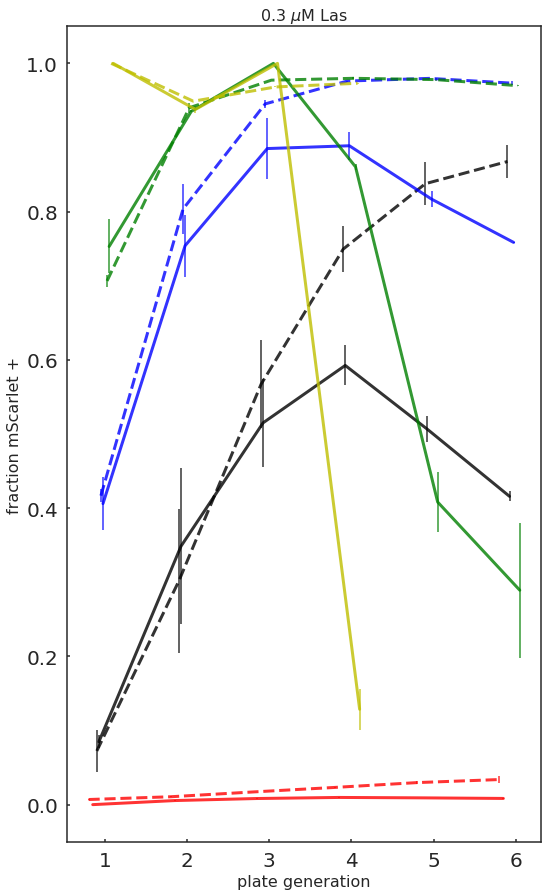

In [21]:
# Plot for 0.3uM Las AHL
fig, ax = plt.subplots()
sal_concs = np.array([0,5,7.5,10,15])
color_palette = sns.color_palette()
alpha = 0.8
lw = 3
elw = 1.5

offsets = np.array([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])/2
# offsets = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6])/2
offsets = np.array([-0.8,-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6,0.8])/4
las_conc = 0.3

for j, sal_conc in enumerate(sal_concs):
    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) & \
                                 (fracs_on_avgs.chlor=='-'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'std'].values
    ax.errorbar(x+offsets[2*j],y,std,color=color_palette[j],linestyle='--',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j + 1])
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j+1],alpha=0.2,linewidth=0)

    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'std'].values
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j])
    ax.errorbar(x+offsets[2*j+1],y,std,color=color_palette[j],linestyle='-',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j],alpha=0.3,linewidth=0)

ax.set_xticks(np.array([1,2,3,4,5,6]))
ax.set_xlabel('plate generation')
# ax[0].set_ylim(0,1000)
ax.set_ylabel('fraction mScarlet +')
ax.set_title('0.3 $\mu$M Las')
# ax[1].set_title('1 $\mu$M Las')
# ax[2].set_title('3 $\mu$M Las')
# ax[2].set_xlim(0,10)
# ax[0].set_ylim(0,50000)
# ax[2].legend(['diff: 0 $\mu$M Sal','diff: 0 $\mu$M Sal','diff: 5 $\mu$M Sal','diff+select: 5 $\mu$M Sal',
#               'diff: 7.5 $\mu$M Sal','diff+select: 7.5 $\mu$M Sal',
#               'diff: 10 $\mu$M Sal','diff+select: 10 $\mu$M Sal','diff: 15 $\mu$M Sal','diff+select: 15 $\mu$M Sal'])
plt.savefig('./mScarlet_sfGFP_diff_flow_300nM_Las.pdf',transparent=True)

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


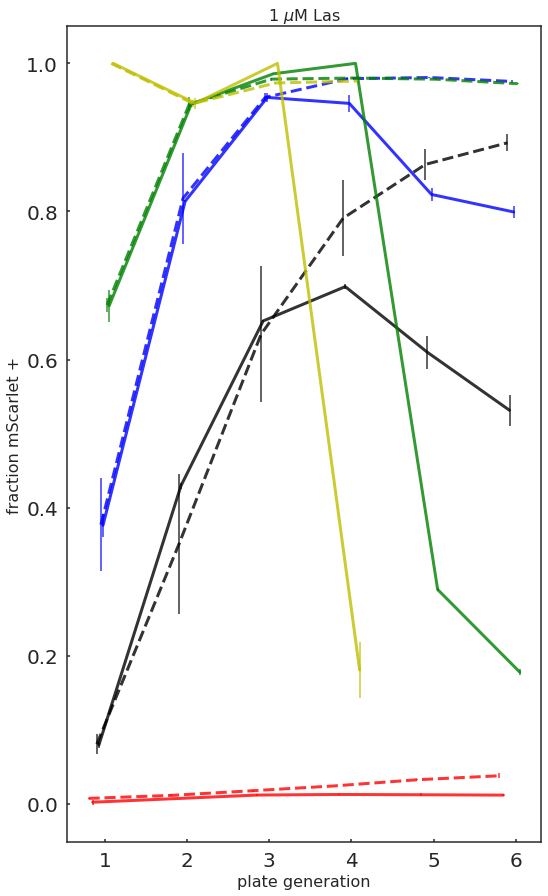

In [22]:
# Plot for 1uM Las AHL
fig, ax = plt.subplots()
sal_concs = np.array([0,5,7.5,10,15])
color_palette = sns.color_palette()
alpha = 0.8
lw = 3
elw = 1.5

offsets = np.array([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])/2
# offsets = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6])/2
offsets = np.array([-0.8,-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6,0.8])/4
las_conc = 1

for j, sal_conc in enumerate(sal_concs):
    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) & \
                                 (fracs_on_avgs.chlor=='-'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'std'].values
    ax.errorbar(x+offsets[2*j],y,std,color=color_palette[j],linestyle='--',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j + 1])
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j+1],alpha=0.2,linewidth=0)

    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'std'].values
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j])
    ax.errorbar(x+offsets[2*j+1],y,std,color=color_palette[j],linestyle='-',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j],alpha=0.3,linewidth=0)

ax.set_xticks(np.array([1,2,3,4,5,6]))
ax.set_xlabel('plate generation')
# ax[0].set_ylim(0,1000)
ax.set_ylabel('fraction mScarlet +')
ax.set_title('1 $\mu$M Las')
# ax[1].set_title('1 $\mu$M Las')
# ax[2].set_title('3 $\mu$M Las')
# ax[2].set_xlim(0,10)
# ax[0].set_ylim(0,50000)
# ax[2].legend(['diff: 0 $\mu$M Sal','diff: 0 $\mu$M Sal','diff: 5 $\mu$M Sal','diff+select: 5 $\mu$M Sal',
#               'diff: 7.5 $\mu$M Sal','diff+select: 7.5 $\mu$M Sal',
#               'diff: 10 $\mu$M Sal','diff+select: 10 $\mu$M Sal','diff: 15 $\mu$M Sal','diff+select: 15 $\mu$M Sal'])
plt.savefig('./mScarlet_sfGFP_diff_flow_1uM_Las.pdf',transparent=True)


C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


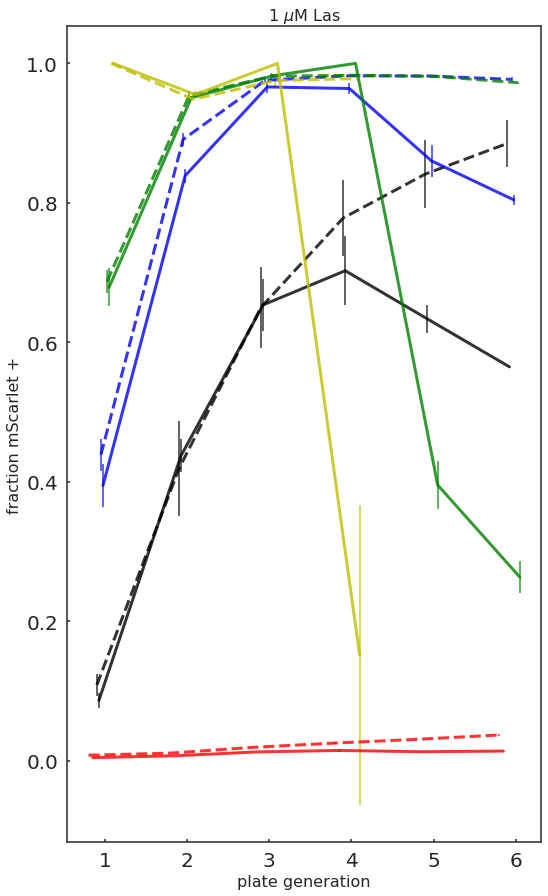

In [23]:
# Plot for 3uM Las AHL
fig, ax = plt.subplots()
sal_concs = np.array([0,5,7.5,10,15])
color_palette = sns.color_palette()
alpha = 0.8
lw = 3
elw = 1.5

offsets = np.array([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])/2
# offsets = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6])/2
offsets = np.array([-0.8,-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6,0.8])/4
las_conc = 3

for j, sal_conc in enumerate(sal_concs):
    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) & \
                                 (fracs_on_avgs.chlor=='-'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'std'].values
    ax.errorbar(x+offsets[2*j],y,std,color=color_palette[j],linestyle='--',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j + 1])
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j+1],alpha=0.2,linewidth=0)

    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'std'].values
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j])
    ax.errorbar(x+offsets[2*j+1],y,std,color=color_palette[j],linestyle='-',capsize=4,alpha=alpha,
                  linewidth=lw,elinewidth=elw)
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j],alpha=0.3,linewidth=0)

ax.set_xticks(np.array([1,2,3,4,5,6]))
ax.set_xlabel('plate generation')
# ax[0].set_ylim(0,1000)
ax.set_ylabel('fraction mScarlet +')
ax.set_title('1 $\mu$M Las')
# ax[1].set_title('1 $\mu$M Las')
# ax[2].set_title('3 $\mu$M Las')
# ax[2].set_xlim(0,10)
# ax[0].set_ylim(0,50000)
# ax[2].legend(['diff: 0 $\mu$M Sal','diff: 0 $\mu$M Sal','diff: 5 $\mu$M Sal','diff+select: 5 $\mu$M Sal',
#               'diff: 7.5 $\mu$M Sal','diff+select: 7.5 $\mu$M Sal',
#               'diff: 10 $\mu$M Sal','diff+select: 10 $\mu$M Sal','diff: 15 $\mu$M Sal','diff+select: 15 $\mu$M Sal'])
plt.savefig('./mScarlet_sfGFP_diff_flow_3uM_Las.pdf',transparent=True)

Now just generate plots with legends that we can crop out to use for generating the final figures

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


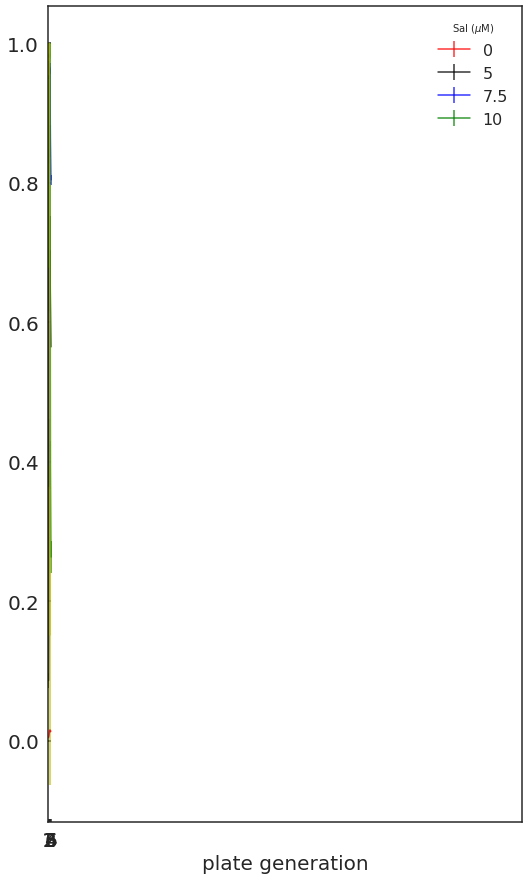

In [24]:
fig, ax = plt.subplots()
las_concs = np.array([0.3,1,3])
sal_concs = np.array([0,5,7.5,10,15])
color_palette = sns.color_palette()
alpha = 0.8

chlor = '+'
offsets = np.array([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])/2
offsets = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6])/2
offsets = np.array([-0.8,-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6,0.8])/4

for j, sal_conc in enumerate(sal_concs):
    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'std'].values
    ax.errorbar(x+offsets[2*j+1],y,std,color=color_palette[j],linestyle='-',capsize=4,alpha=alpha)

ax.set_xticks(np.array([1,2,3,4,5,6]))
ax.set_xlabel('plate generation',fontsize=20)
# ax[0].set_ylim(0,1000)
ax.set_xlim(0,1000)
ax.legend(['0','5','7.5','10'],title='Sal ($\mu$M)',fontsize=16,loc='best')
plt.savefig('./mScarlet_sfGFP_diff_flow_legend1.pdf',transparent=True)

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


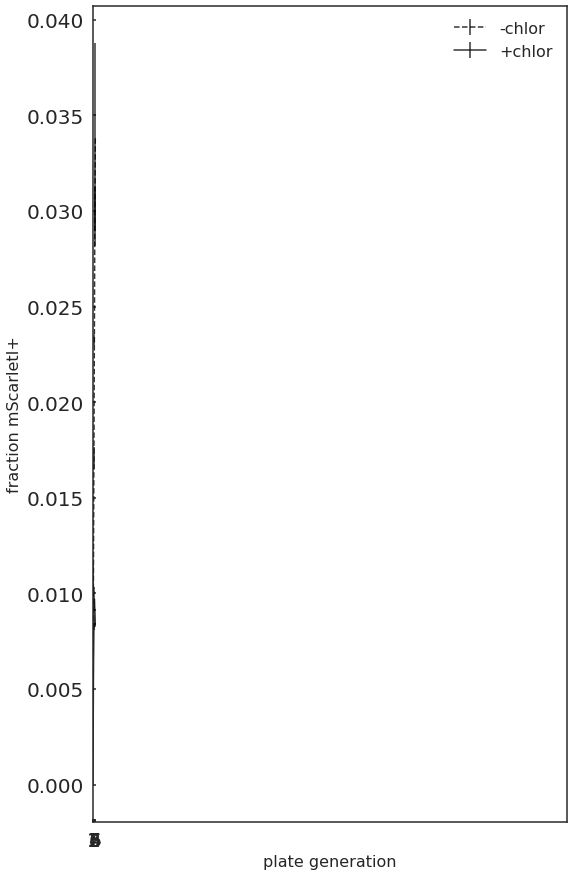

In [25]:
fig, ax = plt.subplots()
las_concs = np.array([0.3,1,3])
sal_concs = np.array([0,5,7.5,10,15])
color_palette = sns.color_palette()
alpha = 0.8

chlor = '+'
offsets = np.array([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])/2
offsets = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6])/2
offsets = np.array([-0.8,-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.6,0.8])/4
las_conc = 0.3

for j, sal_conc in enumerate(sal_concs[0:1]):
    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) & \
                                 (fracs_on_avgs.chlor=='-'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='-'),
                                   'std'].values
    ax.errorbar(x+offsets[2*j],y,std,color='black',linestyle='--',capsize=4,alpha=alpha)
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j + 1])
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j+1],alpha=0.2,linewidth=0)

    x = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'plate'].values
    y = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'fraction'].values
    std = fracs_on_avgs.loc[(fracs_on_avgs.sal==sal_conc) & (fracs_on_avgs.las==las_conc) \
                                 & (fracs_on_avgs.chlor=='+'),
                                   'std'].values
#         ax[i].plot(x,y,'.',alpha=0.5,color=color_palette[2*j])
    ax.errorbar(x+offsets[2*j+1],y,std,color='black',linestyle='-',capsize=4,alpha=alpha)
#         ax[i].fill_between(x,y-std,y+std,color=color_palette[2*j],alpha=0.3,linewidth=0)

ax.set_xticks(np.array([1,2,3,4,5,6]))
ax.set_xlabel('plate generation')
# ax[0].set_ylim(0,1000)
ax.set_ylabel('fraction mScarletI+')
ax.set_xlim(0,1000)
ax.legend(['-chlor','+chlor'],fontsize=16,loc='best')

# ax[2].set_xlim(0,10)
# ax[0].set_ylim(0,50000)
# ax[2].legend(['diff: 0 $\mu$M Sal','diff: 0 $\mu$M Sal','diff: 5 $\mu$M Sal','diff+select: 5 $\mu$M Sal',
#               'diff: 7.5 $\mu$M Sal','diff+select: 7.5 $\mu$M Sal',
#               'diff: 10 $\mu$M Sal','diff+select: 10 $\mu$M Sal','diff: 15 $\mu$M Sal','diff+select: 15 $\mu$M Sal'])
plt.savefig('./mScarlet_sfGFP_diff_flow_legend2.pdf',transparent=True)

Now will generate 2D scatter plots of the flow data for Figure 3E to demonstrate 
the identification of progenitor and differentiated cells

In [29]:
# Plot 3E left
ax.plot(input_df_plate3.loc[input_df_plate3.well=='A01','log10GFP'].values,
     input_df_plate3.loc[input_df_plate3.well=='A01','log10mScarletI'].values,'.',ms=3,alpha=0.03,
       color=sns.color_palette()[3])
ax.plot(input_df_plate3.loc[input_df_plate3.well=='A06','log10GFP'].values,
     input_df_plate3.loc[input_df_plate3.well=='A06','log10mScarletI'].values,'.',ms=3,alpha=0.03,
       color=sns.color_palette()[0])
    
mark1 = Patch(facecolor=sns.color_palette()[3])
mark2 = Patch(facecolor=sns.color_palette()[0])
ax.legend([mark1,mark2],['-Sal','30 $\mu$M Sal'])
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.set_yticks([1,2,3,4,5])
ax.set_xlabel('log10(GFP)')
ax.set_ylabel('log10(mScarletI)')
plt.savefig('./20190225_A1_A6_sfGFP_mscarlet_plot.pdf')

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


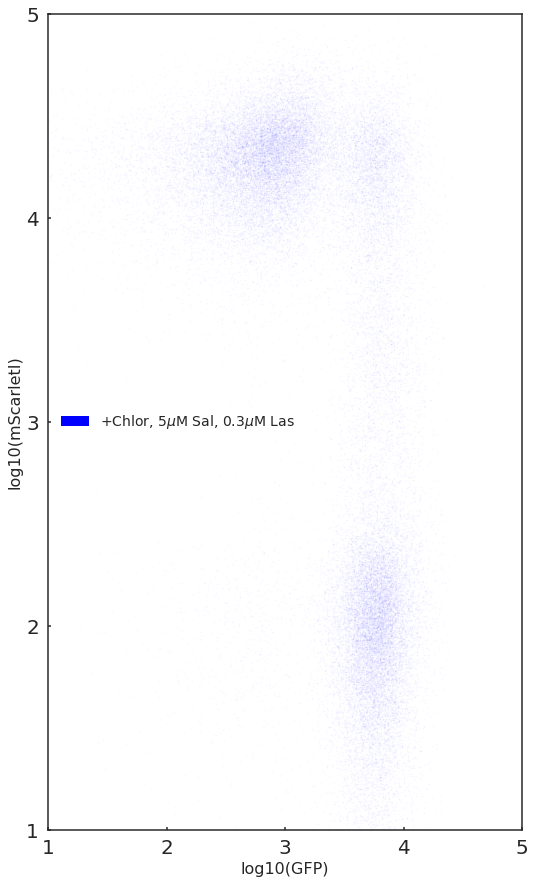

In [28]:
# Plot 3E right
fig,ax=plt.subplots()
ax.plot(input_df_plate3.loc[input_df_plate3.well=='A08','log10GFP'].values,
        input_df_plate3.loc[input_df_plate3.well=='A08','log10mScarletI'].values,
        '.',ms=3,alpha=0.03,
        color = sns.color_palette()[2])
    


mark1 = Patch(facecolor=sns.color_palette()[2])
ax.legend([mark1],['+Chlor, 5$\mu$M Sal, 0.3$\mu$M Las'])
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.set_yticks([1,2,3,4,5])
ax.set_xlabel('log10(GFP)')
ax.set_ylabel('log10(mScarletI)')
plt.savefig('./20190225_A08_plate3_sfGFP_mscarlet_plot.pdf')

Now we will observe the differentiation with selection circuit breaking, generating cells in the fourth plate generation that are GFP+/mScarletI- and no longer are able to differentiate.

C:\Users\Rory\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


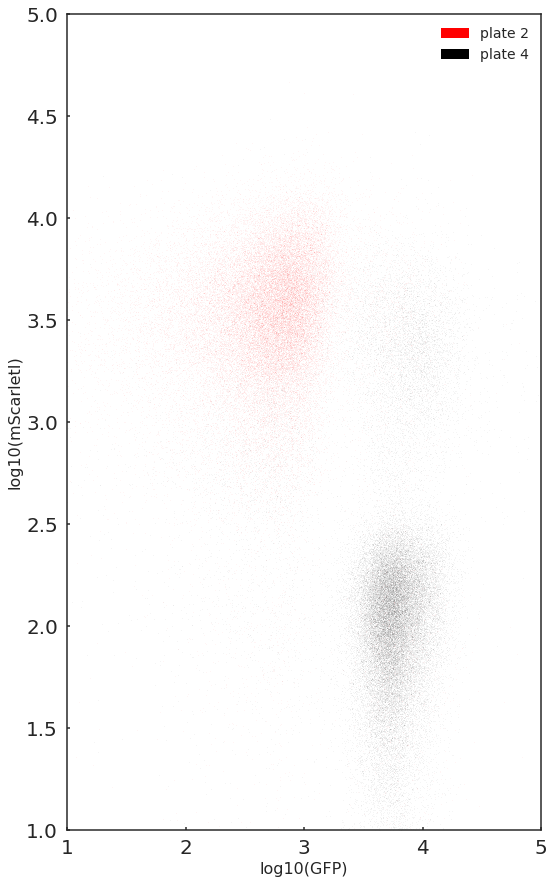

In [32]:
well = 'A11'
fig, ax = plt.subplots()
ax.plot(input_df_plate2.loc[input_df_plate2.well==well,'log10GFP'].values,
     input_df_plate2.loc[input_df_plate2.well==well,'log10mScarletI'].values,'.',ms=1,alpha=0.1)
ax.plot(input_df_plate4.loc[input_df_plate4.well==well,'log10GFP'].values,
     input_df_plate4.loc[input_df_plate4.well==well,'log10mScarletI'].values,'.',ms=1,alpha=0.1)
mark1 = Patch(facecolor=sns.color_palette()[0])
mark2 = Patch(facecolor=sns.color_palette()[1])
ax.legend([mark1,mark2],['plate 2','plate 4'])
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.set_xlabel('log10(GFP)')
ax.set_ylabel('log10(mScarletI)')
plt.savefig('./20190225_A11_plate2_4_sfGFP_mscarlet_plot.pdf')